In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
import tqdm.notebook
import sycomore
from sycomore.units import *

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# PCASL: A typical real sequence may use 750 0.5 ms, 20◦, Hann RF pulses over a 1500 ms period
labelling_length = 1200*ms # ms
flip_angle = 5*deg
gamma = 42.6e6 * Hz/T # Hz/T
Gamma = gamma * 2 * np.pi * rad # rads/Ts

dt = 0.05*ms
idle1, idle2 = 10*ms, 10*ms

r = np.linspace(-0.1, 0.1, 5) * mm
xx, yy = np.meshgrid(r, r)
voxel = np.zeros(xx.shape + (int(round((labelling_length + idle1 + idle2) / dt + 1)),3))

In [3]:
T1 = 1000*ms
T2 = 200*ms
zero = 0*mT/m
G = 2*mT/m
spoil = 400*mT/m
DeltaT = 0.1*ms

In [4]:
flowrate = 0.001 # cm/ms
flowffset = 1.25 # cm
conc = 0.00005 # cm/ms/ms
def trajectory(t):
    """
    Return position in cm for time in ms.
    """
    r = conc * t ** 2 + flowrate * t - flowffset
    return r

In [5]:
trajectory(0), trajectory(labelling_length.convert_to(ms))

(-1.25, 71.95)

In [6]:
t = np.arange(0, labelling_length.convert_to(ms), dt.convert_to(ms))

In [7]:
aliased_labelling_plane = np.arange(10) * (1 / (gamma * G * DeltaT)).convert_to(cm)
aliased_labelling_plane

array([  0.        ,  11.7370892 ,  23.4741784 ,  35.21126761,
        46.94835681,  58.68544601,  70.42253521,  82.15962441,
        93.89671362, 105.63380282])

In [8]:
species = sycomore.Species(T1, T2)

pbar = tqdm.notebook.tqdm(total=xx.size)
for xind, x in enumerate(r):
    for yind, y in enumerate(r):
        pbar.update()

        idle = sycomore.bloch.time_interval(species, dt)
        pulse_20 = sycomore.bloch.pulse(flip_angle)

        t = 0*s
        M = np.array([0,0,1,1])

        record = [[t, M[:3]/M[3]]]
        
        length = idle1
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])
        
        for i in range(int(round(labelling_length / DeltaT))):
            M = pulse_20 @ M
            # record.append([t, M[:3]/M[3]])

            length = DeltaT
            for _ in range(int(round(length / dt))):
                t = t+dt
                position = [x, y + trajectory(t.convert_to(ms)) * cm] # loop to sim full isochromat within a voxel -> can see echo and spoiler
                grad = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, G], position=position)
                M = grad @ M
                record.append([t, M[:3]/M[3]])

        length = idle2
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])
        
        time, magnetization = list(zip(*record))
        magnetization = np.array(magnetization)
        voxel[xind, yind] = magnetization

  0%|          | 0/25 [00:00<?, ?it/s]

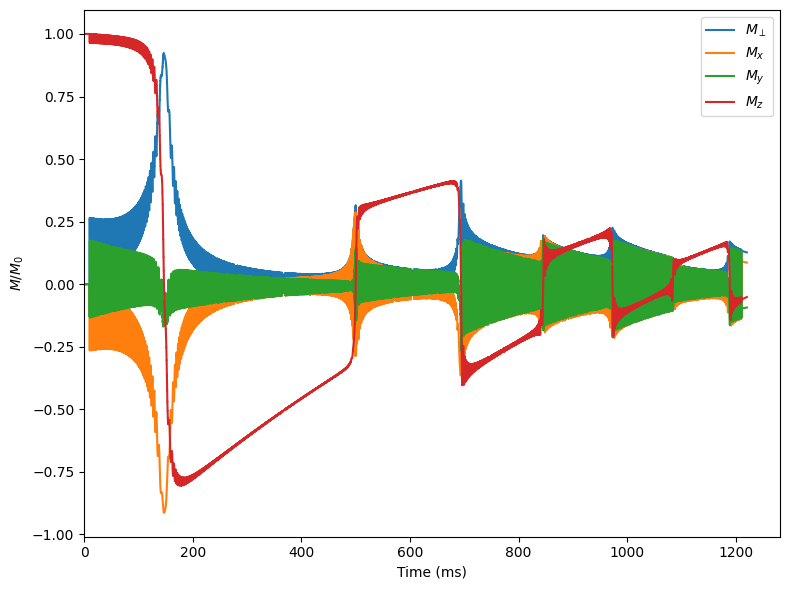

In [10]:
x_axis = [x.convert_to(ms) for x in time]

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(
    x_axis, np.linalg.norm(magnetization[:, :2], axis=-1), label="$M_\perp$")
plt.plot(x_axis, magnetization[:, 0], label="$M_x$")
plt.plot(x_axis, magnetization[:, 1], label="$M_y$")
plt.plot(x_axis, magnetization[:, 2], label="$M_z$")
plt.xlim(0)
plt.xlabel("Time (ms)")
plt.ylabel("$M/M_0$")
plt.legend()
plt.tight_layout()

In [11]:
transverse_mag = (voxel[..., 0] + 1j * voxel[..., 1]).mean(axis=(0, 1))
longitudinal_mag = voxel[..., 2].mean(axis=(0, 1))

In [12]:
longitudinal_mag.min()

-0.7904903062572737

In [13]:
x_axis[longitudinal_mag.argmin()]

179.94999999998834

In [49]:
intersections = x_axis[np.abs(trajectory(x_axis) - aliased_labelling_plane[:, np.newaxis]).argmin(axis=-1)]

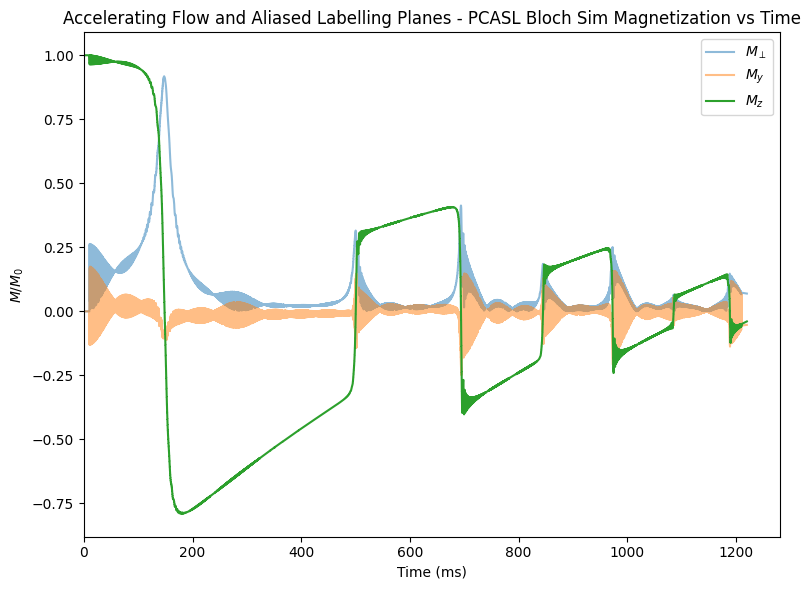

In [33]:
x_axis = [x.convert_to(ms) for x in time]

# fig, (axm, axv) = plt.subplots(2, 1, figsize=(8, 6), dpi=100)
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_axis, np.abs(transverse_mag), label="$M_\perp$", alpha=0.5)
# plt.plot(x_axis, transverse_mag.real, label="$M_x$")
plt.plot(x_axis, transverse_mag.imag, label="$M_y$", alpha=0.5)
plt.plot(x_axis, longitudinal_mag, label="$M_z$")
plt.xlim(0)
plt.xlabel("Time (ms)")
plt.ylabel("$M/M_0$")
plt.legend()
plt.title('Accelerating Flow and Aliased Labelling Planes - PCASL Bloch Sim Magnetization vs Time')

# plt.hlines(aliased_labelling_plane[1:6], t[0], t[-1], linestyles='dashed', color='#c84435')
# plt.plot(t, trajectory(t), color='black')
# plt.xlabel("Time (ms)")
# plt.ylabel("Bolus Location (cm)")

plt.tight_layout()
plt.savefig('PCASL Flow-Induced Adiabatic Inversion - Quadratic and Aliases - Bloch Sim Magnetization vs Time.png')

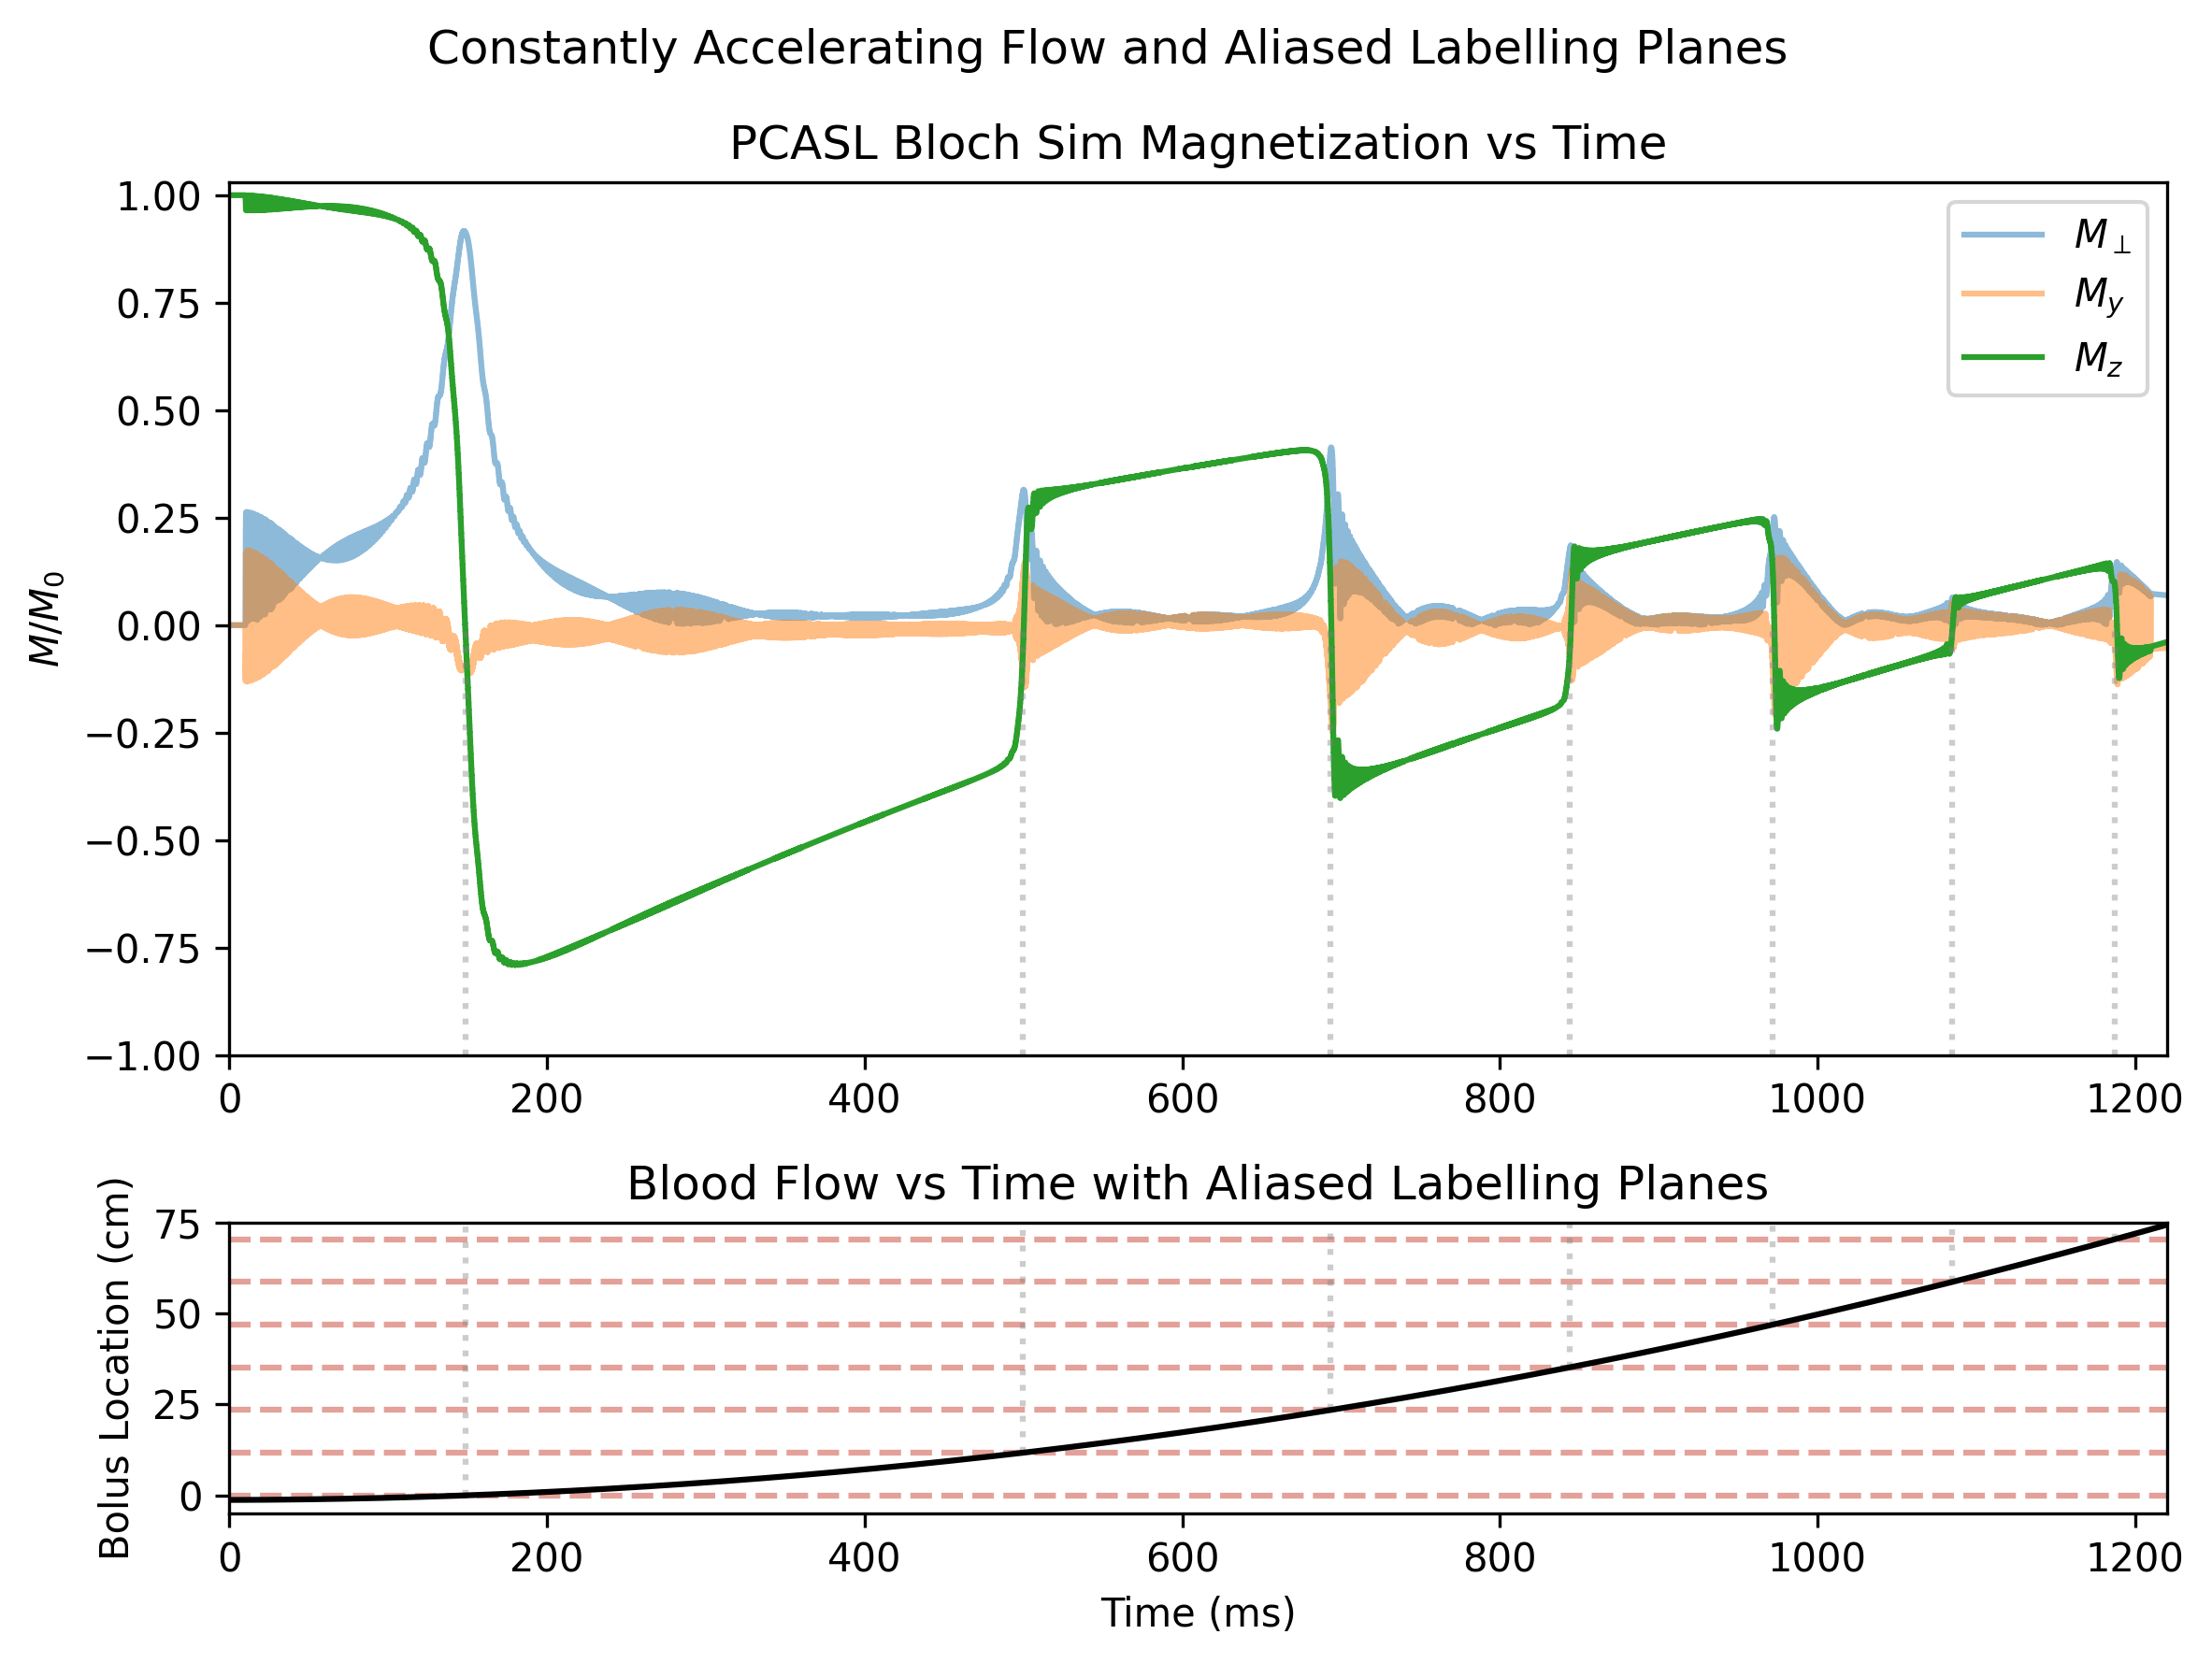

In [64]:
x_axis = np.array([x.convert_to(ms) for x in time])

fig, (axm, axv) = plt.subplots(2, 1, figsize=(8, 6), dpi=300, 
                               gridspec_kw={'height_ratios': [3, 1]})
axm.plot(x_axis, np.abs(transverse_mag), label="$M_\perp$", alpha=0.5)
# axm.plot(x_axis, transverse_mag.real, label="$M_x$")
axm.plot(x_axis, transverse_mag.imag, label="$M_y$", alpha=0.5)
axm.plot(x_axis, longitudinal_mag, label="$M_z$")
axm.vlines(intersections[:7], -1, 0, alpha=0.4, color='grey', linestyle='dotted')
axm.set_xlim(x_axis[0], x_axis[-1])
axm.set_ylim(-1, 1.03)
axm.legend()
axm.set_ylabel("$M/M_0$")
axm.set_title('PCASL Bloch Sim Magnetization vs Time')

axv.hlines(aliased_labelling_plane[:7], x_axis[0], x_axis[-1], 
           alpha=0.5, linestyles='dashed', color='#c84435')
axv.vlines(intersections[:7], trajectory(intersections[:7]), 80, alpha=0.4, color='grey', linestyle='dotted')
axv.plot(x_axis, trajectory(x_axis), color='black')
axv.set_xlim(x_axis[0], x_axis[-1])
axv.set_yticks([0, 25, 50, 75])
axv.set_ylim(-5, 75)
plt.xlabel("Time (ms)")
plt.ylabel("Bolus Location (cm)")
plt.title("Blood Flow vs Time with Aliased Labelling Planes")

plt.suptitle('Constantly Accelerating Flow and Aliased Labelling Planes')
plt.tight_layout()
plt.savefig('poster_figures/Constantly Accelerating Flow and Aliased Labelling Planes.png')